In [4]:
import pandas as pd
import numpy as np
import math

In [5]:
df = pd.read_csv('AB_test_data.csv')

In [6]:
df.head()

,Variant,purchase_TF,date,id
0,A,False,2019-12-26,0x6f9421
1,A,False,2019-08-16,0x59d442
2,A,True,2019-03-18,0x6db8f8
3,A,False,2019-02-13,0x68245d
4,A,False,2019-09-28,0x28566e


# Part 1 - Hypo Test

In [61]:
df_A = df[df['Variant'] == 'A']
df_B = df[df['Variant'] == 'B']

A_conv_rate = len(df_A[df_A['purchase_TF'] == True]) / len(df_A)
B_conv_rate = len(df_B[df_B['purchase_TF'] == True]) / len(df_B)

In [8]:
print(A_conv_rate)
print(B_conv_rate)

0.15206
0.1962


In [9]:
n = len(df_B)
print(n)
print(len(df_A))

5000
50000


Null Hypothesis: B_conv_rate = A_conv_rate

Alternative Hypothesis: B_conv_rate >= A_conv_rate

In [10]:
#Calculate Z-score
z = (B_conv_rate - A_conv_rate) / math.sqrt((A_conv_rate * (1- A_conv_rate))/n)
print(z)

8.692151285198767


Z (alpha) = 1.64

Hence we reject the null hypothesis and conclude that B conversion rate does indeed have significantly higher conversion rate than A.

In [16]:
from scipy import stats
from statsmodels.stats import weightstats as stests

ztest ,pval = stests.ztest(df_B['purchase_TF'], x2=None, value=A_conv_rate,alternative='larger')

print(float(pval))
print(ztest)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

1.940791423245344e-15
7.858694291460287
reject null hypothesis


In [18]:
import statsmodels.api as sm
sm.stats.proportions_ztest(B_conv_rate * n, n, A_conv_rate, alternative='larger')

(7.859480278789498, 1.9286527275536203e-15)

# Part 2 - Optimal Sample Size

Calculate the optimal sample size for a 95% confidence rate and test with 80% power. Conduct the test 10 times using samples of the optimal size. Report results.

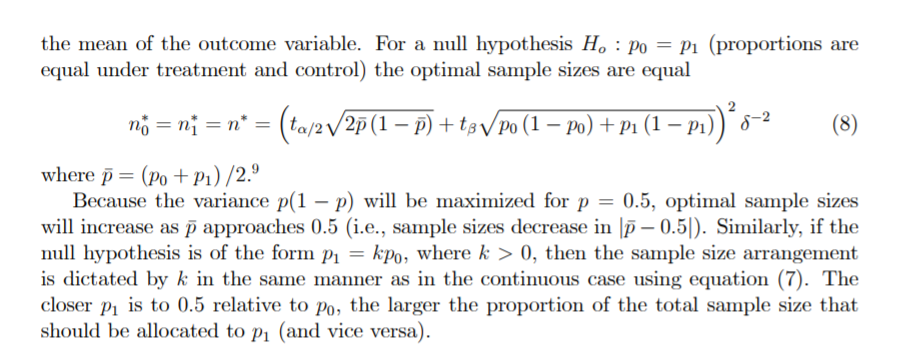

In [26]:
t_alpha = 1.96
p_bar = (A_conv_rate + B_conv_rate) / 2
p0 = A_conv_rate
p1 = B_conv_rate
delta = (B_conv_rate - A_conv_rate)
t_beta = 0.842

optimal = (t_alpha * math.sqrt((2*p_bar*(1-p_bar))) + t_beta * math.sqrt(p0*(1-p0) + p1*(1-p1)))**2 * (1/(delta**2))
print(optimal)

1157.8288770933054


In [33]:
1/(delta**2)

513.257545039889

In [34]:
1/(beta**2)

24.999999999999996

In [49]:
import statsmodels

effect_size = ((B_conv_rate)-(A_conv_rate))/(np.std(df_B['purchase_TF']))
statsmodels.stats.power.tt_solve_power(effect_size=effect_size, nobs=None, alpha=0.05, power=0.8, alternative='larger')

26.73497965510538

In [44]:
np.std(df_B['purchase_TF'])

0.39712159346980874

In [48]:
effect_size = (B_conv_rate - A_conv_rate)/(np.std(df_B['purchase_TF']))

power_analysis = statsmodels.stats.power.TTestIndPower()
power_analysis.solve_power(effect_size=effect_size, nobs1=None, alpha=0.05, power=0.8, ratio=1, alternative='larger')

1001.5535737907313

## Sampling Optimal Sizes from Data

Conduct the test 10 times using samples of the optimal size. Report results.

In [65]:
list_of_z_scores = []

for i in range(10):
    sample = df_B.sample(n=1157,axis=0)
    B_conv_rate = len(sample[sample['purchase_TF'] == True]) / len(sample)
    
    z = (B_conv_rate - A_conv_rate) / math.sqrt((A_conv_rate * (1- A_conv_rate))/len(sample))
    list_of_z_scores.append(z)

list_of_z_scores


[4.099125285030468,
 4.180998768001154,
 3.8535048361184105,
 4.672239665825269,
 4.754113148795953,
 3.7716313531477264,
 3.7716313531477264,
 4.4266192169132115,
 3.68975787017704,
 3.280390455323612]

In [63]:
list_of_success = []

for i in list_of_z_scores:
    if i > 1.96:
        list_of_success.append(True)
    else:
        list_of_success.append(False)

In [64]:
sum(list_of_success)/len(list_of_success)

1.0

## Conduct Sequential Test

Conduct a sequential test for the 10 samples. For any of the samples, were you able to stop the test prior to using the full sample? What was the average number of iterations required to stop the test?

Under H0: P(x=1) = 0.15206

Under H1: P(x=1) = 0.1962

Type I error: 5%

Type II error: 20%

In [74]:
upper = np.log(1/0.05)
lower = np.log(0.2)

p0 = 0.15206
p1 = 0.1962

In [123]:
print(upper)
print(lower)

2.995732273553991
-1.6094379124341003


In [236]:
def feed_criteria(total_criteria,sample,number):
    global len_log
    global success_log
    
    if (total_criteria <= lower):
        print("test stopped and accept H0")
        print(len(log))
        len_log.append(len(log))
        success_log.append(0)
    elif total_criteria >= upper:
        print('test stopped and accept H1')
        print(len(log))
        len_log.append(len(log))
        success_log.append(1)

    else:
        #print("keep going")
        if sample.purchase_TF.iloc[number] == True:
            criteria = np.log(p1/p0)
        else:
            criteria = np.log((1-p1)/(1-p0))
        log.append(criteria)
        end_criteria = sum(log)
        number = number +1
        #print("current number:",end_criteria)
        feed_criteria(end_criteria,sample,number)

In [240]:
len_log = []
success_log = []
for i in range(100000):
    sample = df_B.sample(n=1157,axis=0)
    number = 0
    log = []
    feed_criteria(0,sample,number)


test stopped and accept H1
830
test stopped and accept H1
448
test stopped and accept H0
157
test stopped and accept H1
185
test stopped and accept H1
136
test stopped and accept H1
130
test stopped and accept H1
163
test stopped and accept H1
174
test stopped and accept H1
858
test stopped and accept H1
185
test stopped and accept H0
163
test stopped and accept H1
105
test stopped and accept H0
134
test stopped and accept H0
215
test stopped and accept H0
100
test stopped and accept H1
340
test stopped and accept H1
299
test stopped and accept H0
186
test stopped and accept H1
243
test stopped and accept H1
300
test stopped and accept H1
322
test stopped and accept H0
290
test stopped and accept H0
215
test stopped and accept H0
123
test stopped and accept H1
372
test stopped and accept H1
463
test stopped and accept H1
63
test stopped and accept H1
137
test stopped and accept H1
403
test stopped and accept H1
393
test stopped and accept H0
59
test stopped and accept H1
614
test stopp

test stopped and accept H1
312
test stopped and accept H0
88
test stopped and accept H1
111
test stopped and accept H0
71
test stopped and accept H1
151
test stopped and accept H1
209
test stopped and accept H0
325
test stopped and accept H1
871
test stopped and accept H1
486
test stopped and accept H1
124
test stopped and accept H1
252
test stopped and accept H1
163
test stopped and accept H1
242
test stopped and accept H0
325
test stopped and accept H1
457
test stopped and accept H1
386
test stopped and accept H1
92
test stopped and accept H1
162
test stopped and accept H1
843
test stopped and accept H0
198
test stopped and accept H0
573
test stopped and accept H1
214
test stopped and accept H1
313
test stopped and accept H1
609
test stopped and accept H1
398
test stopped and accept H1
280
test stopped and accept H1
111
test stopped and accept H0
256
test stopped and accept H1
353
test stopped and accept H1
793
test stopped and accept H1
208
test stopped and accept H1
121
test stoppe

IndexError: single positional indexer is out-of-bounds

In [241]:
sum(len_log)/len(len_log)

289.72549019607845

In [242]:
sum(success_log)/len(success_log)

0.8082788671023965

In [206]:
print(np.log((1-p1)/p0))
print(np.log(p1/p0))

1.6650753022148101
0.25485936733097214
